# Распознавание объектов на изображениях из набора данных CIFAR-10

Пример из курса ["Программирование глубоких нейронных сетей на Python"](https://www.asozykin.ru/courses/nnpython).

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

In [ ]:
import numpy as np
import keras
from keras.datasets import cifar10 
from keras.models import Sequential 
from keras.layers import Dense, Flatten 
from keras.layers import Activation, BatchNormalization 
from keras.layers import Dropout 
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.utils import np_utils 
from keras.preprocessing import image
from keras import regularizers 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [ ]:
# Количество классов изображений
nb_classes = 10
# Размер изображений
img_rows, img_cols = 32, 32
# Количество каналов в изображении: RGB
img_channels = 3
# Названия классов из набора данных CIFAR-10
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

## Подготовка данных

**Загружаем данные**

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

**Просмотр примеров данных**

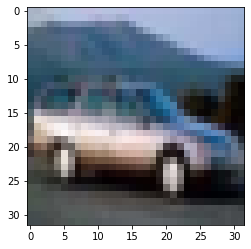

Номер класса: [1]
Тип объекта: автомобиль


In [ ]:
n = 4
plt.imshow(X_train[n])
plt.show()
print("Номер класса:", y_train[n])
print("Тип объекта:", classes[y_train[n][0]])

**Нормализуем данные**

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

**Преобразуем правильные ответы в формат one hot encoding**

In [ ]:
#z-score
mean = np.mean(X_train,axis=(0,1,2,3))
std = np.std(X_train,axis=(0,1,2,3))
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)

In [ ]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Создаем нейронную сеть

In [ ]:
# Создаем последовательную модель
weight_decay = 1e-4
model = Sequential()
# Первый сверточный слой
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
# Второй сверточный слой
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Третий сверточный слой
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

# Четвертый сверточный слой
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
#слой подвыборки
model.add(MaxPooling2D(pool_size=(2,2)))
# Слой регуляризации Dropout
model.add(Dropout(0.3))

#Пятый сверточный слой
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

#6 сверточный слой
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Полносвязный слой для классификации
#model.add(Dense(512, activation='relu'))
# Слой регуляризации Dropout
#model.add(Dropout(0.5))
# Выходной полносвязный слой
model.add(Dense(nb_classes, activation='softmax'))

**Печатаем информацию о сети**

In [ ]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)       

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train)

In [ ]:

batch_size = 64

In [ ]:
#компилируем модель
opt_rms = keras.optimizers.RMSprop(learning_rate=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, 
              metrics=['accuracy'])

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(X_test,Y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/125
781/781 [==============================] - 31s 36ms/step - loss: 2.3736 - accuracy: 0.3409 - val_loss: 1.4291 - val_accuracy: 0.5545
Epoch 2/125
781/781 [==============================] - 27s 34ms/step - loss: 1.4907 - accuracy: 0.5599 - val_loss: 1.1947 - val_accuracy: 0.6285
Epoch 3/125
781/781 [==============================] - 27s 34ms/step - loss: 1.2387 - accuracy: 0.6283 - val_loss: 1.1245 - val_accuracy: 0.6718
Epoch 4/125
781/781 [==============================] - 27s 35ms/step - loss: 1.0995 - accuracy: 0.6724 - val_loss: 1.0012 - val_accuracy: 0.7145
Epoch 5/125
781/781 [==============================] - 29s 38ms/step - loss: 1.0119 - accuracy: 0.7032 - val_loss: 1.0809 - val_accuracy: 0.7071
Epoch 6/125
781/781 [==============================] - 27s 35ms/step - loss: 0.9481 - accuracy: 0.7264 - val_loss: 0.9188 - val_accuracy: 0.7390
Epoch 7/125
781/781 [==============================] - 27s 35ms/step - loss: 0.9145 - accuracy: 0.7389 - val_loss: 0.9157 - val_ac

## Обучаем нейронную сеть

## Оцениваем качетсво обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))

Точность работы на тестовых данных: 90.37%


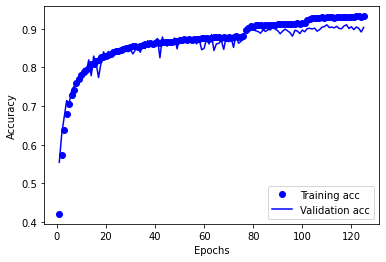

In [ ]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Сохраняем обученную нейронную сеть

In [ ]:
model_json = model.to_json()
json_file = open("cifar10_model.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights("cifar10_model.h5")

In [ ]:
!ls

cifar10_model.h5  cifar10_model.json  sample_data


In [ ]:
from google.colab import files

In [ ]:
files.download("cifar10_model.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("cifar10_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Применяем сеть для распознавания объектов на изображениях

**Просмотр изображения из набора данных для тестирования**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


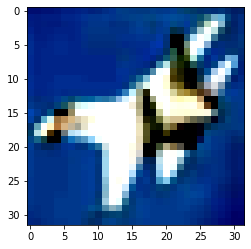

In [ ]:
index=10
plt.imshow(X_test[index])
plt.show()

**Преобразование тестового изображения**

In [ ]:
x = X_test[index]
x = np.expand_dims(x, axis=0)

**Запуск распознавания**

In [ ]:
prediction = model.predict(x)

**Печатаем результаты распознавания**

In [ ]:
print(prediction)

[[9.9995375e-01 4.2394053e-08 3.2246653e-06 2.0189729e-05 1.6524800e-05
  4.8946822e-06 7.4688529e-08 2.8878706e-08 5.4438857e-07 8.1301539e-07]]


**Преобразуем результаты из формата one hot encoding**

In [ ]:
prediction = np.argmax(prediction)
print(classes[prediction])

самолет


**Печатаем правильный ответ**

In [ ]:
print(classes[y_test[index][0]])

самолет


## Распознаем дополнительное изображение

In [ ]:
from google.colab import files

files.upload()

Saving auto.jpg to auto.jpg


{'auto.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x04\xb0\x07\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x02\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x03\x06\x01\x02\x07\x00\x08\t\xff\xc4\x00]\x10\x00\x01\x03\x03\x02\x04\x03\x05\x05\x05\x05\x06\x03\x03\x01\x19\x01\x02\x03\x04\x00\x05\x11\x12!\x06\x131A"Qa\x07\x142q\x81\x15#B\x91\xa1\x08R\xb1\xc1\xd13br\xe1\xf0\x16$C\x82\

Проверяем загрузку файлов

In [ ]:
!ls

auto.jpg  cifar10_model.h5  cifar10_model.json	pferde.jpg  sample_data


**Смотрим загруженную картинку**

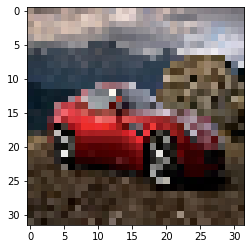

In [ ]:
img_path = 'auto.jpg'
img = image.load_img(img_path, target_size=(32, 32))
plt.imshow(img)
plt.show()

**Преобразуем картинку в массив для распознавания**

In [ ]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

**Запускаем распознавание**

In [ ]:
prediction = model.predict(x)
prediction = np.argmax(prediction)
print(classes[prediction])

автомобиль


# **выводы**
Мы достигли хороших результатов по достаточно сложной проблеме. Одна ко мы все еще далеки от достижений мирового уровня.
Ниже я приведу некоторые идеи, которые могут повысить производительность модели:
- **увеличения количества эпох при обучении.** Обычно для больших светрочных сетей требуется сотни и тысячи эпох, чтобы получить приемлимое качество.
- **увеличение данных на изображениях**. Объекты на изображениях различаются по положению. Еще одним способом повышения качества модели можно достичь с помощью увеличения данных. К числу этих методов можно отнести стандартизацию, случайные сдвиги и горизонтальные перевороты изображений. 
- **Углубить топологию сети.** Наша сеть глубокая. Но для решения такого типа задач, можно разработать еще более крупные сети. Суда может включаться и больше карт функций, которые находятся ближе ко входу и возможно менее агрессивное объединение.

Наша модель не переобучена. Есть много возможностей по улучшению нашей модели. 